In [39]:
pip install gensim joblib transformers

Note: you may need to restart the kernel to use updated packages.


In [1]:
pip install transformers==3.1.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 884.0/884.0 kB 7.7 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.4/97.4 kB 9.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 12.6 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 13.3 MB/s eta 0:00:00a 0:00:01
  error: subprocess-exited-with-error
  
  × Building wheel for tokenizers (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [48 lines of output]
      /private/var/folders/9s/df6cd13d1zqfnk6s1r2x5_lh0000gn/T/pip-build-env-sx7i8u1a/overlay/lib/python3.9/site-packages/setuptools/dist.py:318: InformationOnly: Normalizing '0.8.1.rc2' to '0.8.1rc2'
        self.metadata.version = self._normalize_version(self.metadata.version)
      running bdist_wheel
      running build
      running build_py
      

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from gensim import corpora, models
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from joblib import Parallel, delayed
import nltk
from transformers import pipeline

### Exploratiom -- EIC Data

In [3]:
data = pd.read_csv("TCPD_GE_All_States_2024-1-27.csv")

/var/folders/9s/df6cd13d1zqfnk6s1r2x5_lh0000gn/T/ipykernel_6695/4237615685.py:1: DtypeWarning: Columns (17,36,37,38,39,40,41,42,43) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("TCPD_GE_All_States_2024-1-27.csv")


In [4]:
data.shape[0]

91669

In [ ]:
data.head()

,State_Name,Assembly_No,Constituency_No,Year,month,Poll_No,DelimID,Position,Candidate,Sex,...,No_Terms,Turncoat,Incumbent,Recontest,MyNeta_education,TCPD_Prof_Main,TCPD_Prof_Main_Desc,TCPD_Prof_Second,TCPD_Prof_Second_Desc,Election_Type
0,Andaman_&_Nicobar_Islands,17,1,2019,4.0,0,4,1,KULDEEP RAI SHARMA,M,...,1.0,False,False,True,Graduate Professional,Business,NaN,Social Work,NaN,Lok Sabha Election (GE)
1,Andaman_&_Nicobar_Islands,17,1,2019,4.0,0,4,2,VISHAL JOLLY,M,...,0.0,False,False,False,Graduate Professional,Liberal Profession or Professional,Lawyer,NaN,NaN,Lok Sabha Election (GE)
2,Andaman_&_Nicobar_Islands,17,1,2019,4.0,0,4,3,PARITOSH KUMAR HALDAR,M,...,0.0,False,False,False,Post Graduate,Agriculture,NaN,NaN,NaN,Lok Sabha Election (GE)
3,Andaman_&_Nicobar_Islands,17,1,2019,4.0,0,4,4,SANJAY MESHACK,M,...,0.0,False,False,True,12th Pass,Business,NaN,Politics,Municipality Member,Lok Sabha Election (GE)
4,Andaman_&_Nicobar_Islands,17,1,2019,4.0,0,4,5,PRAKASH MINJ,M,...,0.0,False,False,False,Post Graduate,Social Work,NaN,NaN,NaN,Lok Sabha Election (GE)


In [67]:
winners_df = data[data['Position'] == 1]
winners_df.rename(columns={'Sex': 'winner_gender'}, inplace=True)

/var/folders/9s/df6cd13d1zqfnk6s1r2x5_lh0000gn/T/ipykernel_6695/3662230209.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  winners_df.rename(columns={'Sex': 'winner_gender'}, inplace=True)


In [70]:
election_years = [1991, 1996, 1998, 1999, 2004, 2009, 2014, 2019] 

# Initialize a dictionary to store results
percentage_female_winners = {}

for year in election_years:
    # Filter the DataFrame for the current election year
    df_filtered = winners_df[winners_df['Year'] == year]
    
    # Calculate the percentage of constituencies with female winners
    percentage = (df_filtered['winner_gender'] == 'F').mean() * 100
    percentage_female_winners[year] = percentage

# Display the results
for year, percentage in percentage_female_winners.items():
    print(f"In {year}, {percentage:.2f}% of constituencies had female winners.")

In 1991, 7.60% of constituencies had female winners.
In 1996, 7.88% of constituencies had female winners.
In 1998, 8.26% of constituencies had female winners.
In 1999, 9.39% of constituencies had female winners.
In 2004, 8.59% of constituencies had female winners.
In 2009, 10.66% of constituencies had female winners.
In 2014, 11.86% of constituencies had female winners.
In 2019, 14.31% of constituencies had female winners.


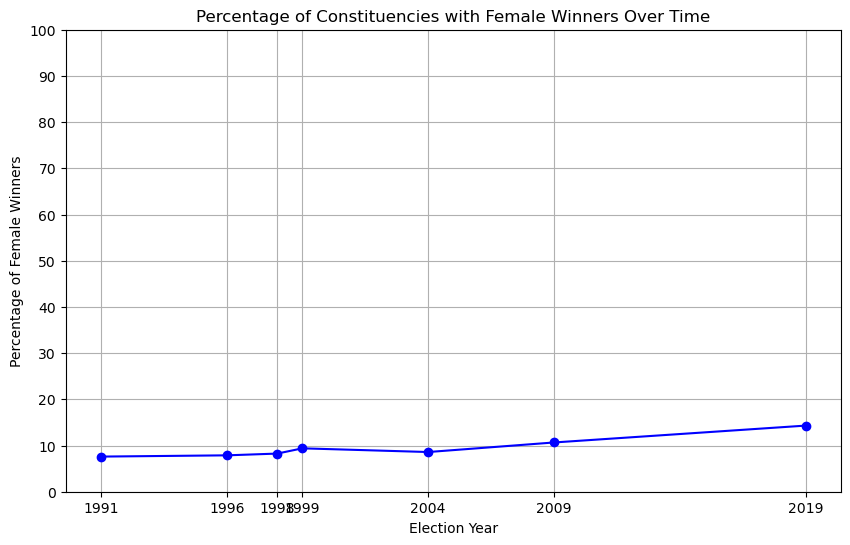

In [69]:
import matplotlib.pyplot as plt

# Assuming percentage_female_winners is a dictionary with years as keys and percentages as values
years = list(percentage_female_winners.keys())
percentages = list(percentage_female_winners.values())

plt.figure(figsize=(10, 6))
plt.plot(years, percentages, marker='o', linestyle='-', color='blue')
plt.title('Percentage of Constituencies with Female Winners Over Time')
plt.xlabel('Election Year')
plt.ylabel('Percentage of Female Winners')
plt.grid(True)
plt.xticks(years)
plt.yticks(range(0, 101, 10))  # Adjust depending on your data's range
plt.show()

In [ ]:
data.describe()

,Assembly_No,Constituency_No,Year,month,Poll_No,DelimID,Position,Votes,Valid_Votes,Electors,N_Cand,Turnout_Percentage,Vote_Share_Percentage,Margin,Margin_Percentage,ENOP,Party_ID,Contested,Last_Party_ID,No_Terms
count,91669.000000,91669.000000,91669.000000,88590.000000,91669.000000,91669.000000,91669.000000,9.166500e+04,9.166900e+04,9.164900e+04,91669.000000,91649.000000,91649.000000,91668.000000,91649.000000,91649.000000,91435.000000,90562.000000,17805.000000,90562.000000
mean,11.447360,21.916635,1996.553033,4.958901,0.031057,3.181861,12.038388,5.250177e+04,6.612916e+05,1.126394e+06,22.884628,60.589966,9.025739,24987.691037,4.226507,2.881454,9080.210587,1.389998,7504.654591,0.251618
std,3.792191,18.847940,14.470426,2.917823,0.175288,0.631886,28.582320,1.110214e+05,2.907476e+05,4.245669e+05,48.158165,141.775634,16.656845,64193.596108,9.652279,0.817266,4241.367095,1.034613,4577.733355,0.797915
min,3.000000,1.000000,1962.000000,1.000000,0.000000,1.000000,1.000000,0.000000e+00,0.000000e+00,1.000000e+00,1.000000,0.000000,0.000000,0.000000,0.000000,1.050000,1.000000,1.000000,9.000000,0.000000
25%,9.000000,7.000000,1989.000000,4.000000,0.000000,3.000000,3.000000,1.002000e+03,4.464150e+05,8.403100e+05,9.000000,49.970000,0.150000,40.000000,0.010000,2.270000,5533.000000,1.000000,3482.000000,0.000000
50%,11.000000,17.000000,1996.000000,4.000000,0.000000,3.000000,7.000000,3.309000e+03,6.327130e+05,1.103327e+06,14.000000,58.200000,0.520000,409.000000,0.060000,2.700000,10809.000000,1.000000,8247.000000,0.000000
75%,15.000000,32.000000,2009.000000,5.000000,0.000000,4.000000,13.000000,2.826300e+04,8.349570e+05,1.409202e+06,23.000000,66.430000,6.160000,8549.250000,1.670000,3.330000,10809.000000,1.000000,10809.000000,0.000000
max,17.000000,86.000000,2021.000000,12.000000,2.000000,4.000000,480.000000,1.068569e+06,1.763757e+06,3.623806e+06,480.000000,15300.520000,97.690000,712215.000000,97.190000,10.000000,25160.000000,14.000000,18721.000000,11.000000


In [ ]:
females = data[data['Sex']=='F']

In [ ]:
females.head()

,State_Name,Assembly_No,Constituency_No,Year,month,Poll_No,DelimID,Position,Candidate,Sex,...,No_Terms,Turncoat,Incumbent,Recontest,MyNeta_education,TCPD_Prof_Main,TCPD_Prof_Main_Desc,TCPD_Prof_Second,TCPD_Prof_Second_Desc,Election_Type
9,Andaman_&_Nicobar_Islands,17,1,2019,4.0,0,4,10,MINATI BISWAS,F,...,0.0,False,False,False,8th Pass,Small Business or Self-employed,Self-employed,NaN,NaN,Lok Sabha Election (GE)
16,Andhra_Pradesh,17,1,2019,4.0,0,4,1,GODDETI. MADHAVI,F,...,1.0,False,False,False,Graduate Professional,Social Work,NaN,NaN,NaN,Lok Sabha Election (GE)
21,Andhra_Pradesh,17,1,2019,4.0,0,4,6,SHRUTI DEVI VYRICHERLA,F,...,0.0,False,False,False,Doctorate,Politics,Ex MLA,Agriculture,NaN,Lok Sabha Election (GE)
23,Andhra_Pradesh,17,1,2019,4.0,0,4,8,NARAVA SATYAVATHI,F,...,0.0,False,False,False,10th Pass,Other,Household,NaN,NaN,Lok Sabha Election (GE)
50,Andhra_Pradesh,17,3,2019,4.0,0,4,14,Surya Bhavani. K,F,...,0.0,False,False,False,8th Pass,Other,Household,NaN,NaN,Lok Sabha Election (GE)


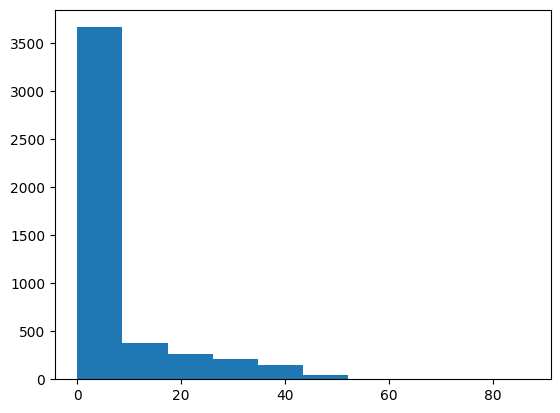

In [ ]:
plt.hist(females['Margin_Percentage'])
plt.show()

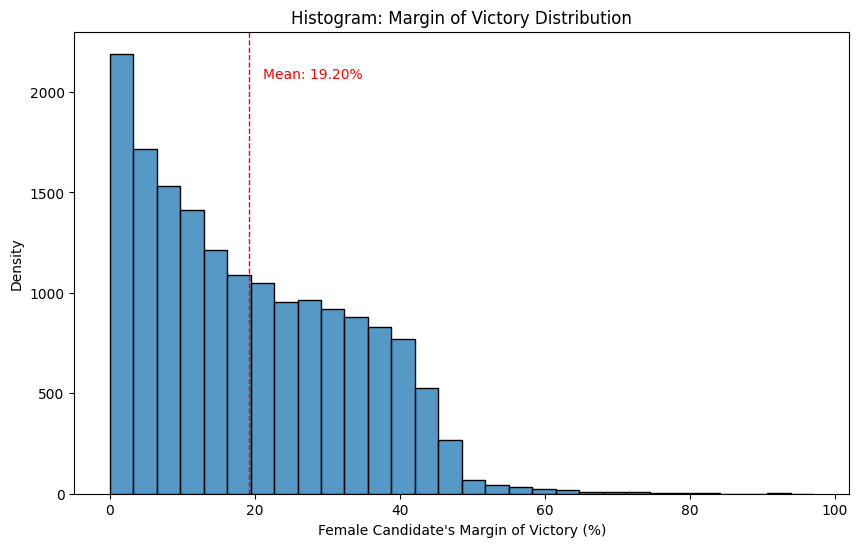

In [ ]:
# Filter out only the rows with the first and second positions, which are winners and runners-up.
close_elections = data[data['Position'].isin([1, 2])]

# Plot the histogram using the 'Margin_Percentage' column.
plt.figure(figsize=(10, 6))
sns.histplot(close_elections['Margin_Percentage'], bins=30, kde=False)
plt.title('Histogram: Margin of Victory Distribution')
plt.xlabel('Female Candidate\'s Margin of Victory (%)')
plt.ylabel('Density')
plt.axvline(close_elections['Margin_Percentage'].mean(), color='red', linestyle='dashed', linewidth=1)
plt.text(close_elections['Margin_Percentage'].mean() * 1.1, max(plt.ylim()) * 0.9,
         'Mean: {:.2f}%'.format(close_elections['Margin_Percentage'].mean()),
         color = 'red')
plt.show()

In [ ]:
filtered_data = data[(data['Year'] >= 1990) & (data['Year'] <= 2019)]

<ipython-input-18-007a6e30d7b9>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data.loc[filtered_data['Position'] == 1, 'Margin_Percentage_Signed'] = filtered_data['Margin_Percentage']


Text(-5.911716915866995, 1037.6100000000001, 'Mean: -5.37%')

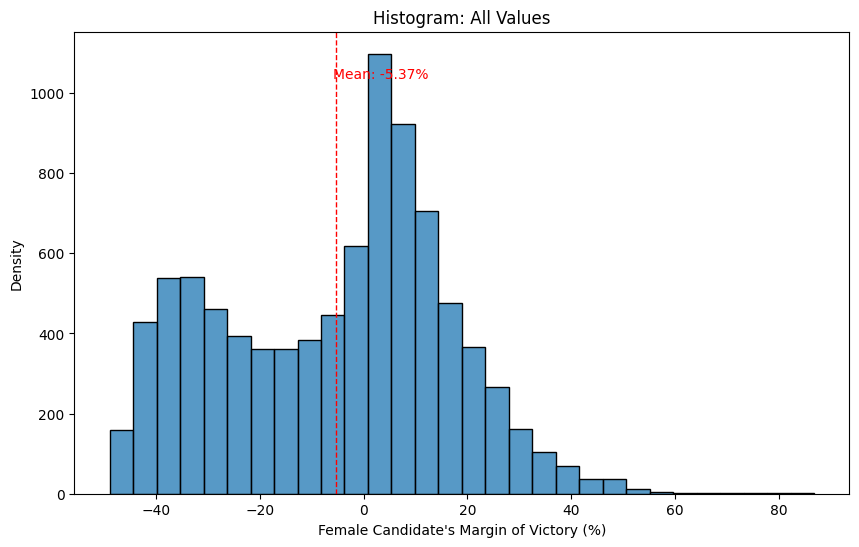

In [ ]:
# Assign positive values to the winners
filtered_data.loc[filtered_data['Position'] == 1, 'Margin_Percentage_Signed'] = filtered_data['Margin_Percentage']

# Assign negative values to the runners-up
filtered_data.loc[filtered_data['Position'] == 2, 'Margin_Percentage_Signed'] = -filtered_data['Margin_Percentage']

# Now we can plot the histogram including both negative and positive values.
plt.figure(figsize=(10, 6))
sns.histplot(filtered_data['Margin_Percentage_Signed'].dropna(), bins=30, kde=False)
plt.title('Histogram: All Values')
plt.xlabel('Female Candidate\'s Margin of Victory (%)')
plt.ylabel('Density')
plt.axvline(filtered_data['Margin_Percentage_Signed'].mean(), color='red', linestyle='dashed', linewidth=1)
plt.text(filtered_data['Margin_Percentage_Signed'].mean() * 1.1, max(plt.ylim()) * 0.9,
         'Mean: {:.2f}%'.format(filtered_data['Margin_Percentage_Signed'].mean()),
         color = 'red')

In [4]:
# Pivot the table to have years as columns and fill with gender
df_pivoted = data.pivot_table(index='Constituency_No', columns='Year', values='Sex', aggfunc='first')

# Convert genders to binary variables (1 for Male, 0 for Female)
df_pivoted = df_pivoted.applymap(lambda x: 1 if x == 'M' else 0)

# Reset index to make 'constituency' a column again
df_pivoted.reset_index(inplace=True)

# Rename columns to indicate they represent treatment years
df_pivoted.columns = ['Constituency_No'] + [f'treatment_{year}' for year in df_pivoted.columns if year != 'Constituency_No']

print(df_pivoted)

    Constituency_No  treatment_1962  treatment_1963  treatment_1964  \
0                 1               1               1               0   
1                 2               1               0               0   
2                 3               1               0               0   
3                 4               1               0               0   
4                 5               1               0               0   
..              ...             ...             ...             ...   
81               82               1               0               0   
82               83               1               0               0   
83               84               1               0               0   
84               85               1               0               0   
85               86               1               0               0   

    treatment_1965  treatment_1967  treatment_1968  treatment_1969  \
0                0               1               0               0   
1      

/var/folders/9s/df6cd13d1zqfnk6s1r2x5_lh0000gn/T/ipykernel_6695/1724505094.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_pivoted = df_pivoted.applymap(lambda x: 1 if x == 'M' else 0)


In [6]:
data2 = pd.read_csv("/Users/bhavyapandey/Downloads/dataset_final.csv")

In [10]:
merged_df = pd.merge(data2, df_pivoted, on='Constituency_No', how='outer')

In [11]:
merged_df.head()

,id,date,ls_number,ministry,question_type,question_text,answer_text,member,party,state,...,treatment_2012,treatment_2013,treatment_2014,treatment_2015,treatment_2016,treatment_2017,treatment_2018,treatment_2019,treatment_2020,treatment_2021
0,17350913.0,1999-12-09,13.0,Rural Development,Unstarred,(a) whether any scheme is under consideation o...,MINISTER OF STATE FOR RURAL DEVELOPMENT (SHRI ...,ABDUL RASHID SHAHEEN,JKN,Jammu & Kashmir,...,0,0,1,0,1,1,1,1,0,0
1,17354313.0,1999-12-01,13.0,Prime Minister,Unstarred,(a) whether the Government propose to conduct ...,THE MINISTER OF STATE IN THE DEPARTMENT OF ATO...,T. GOVINDAN,CPM,Kerala,...,0,0,1,0,1,1,1,1,0,0
2,17353813.0,1999-12-02,13.0,Rural Development,Unstarred,(a) The guidelines and directions issued by th...,Minister of State for RURAL DEVELOPMENT (SHRI ...,SAMAR CHOWDHURY,CPM,Tripura,...,0,0,1,0,1,1,1,1,0,0
3,10021313.0,2004-02-04,13.0,Shipping,Unstarred,(a) the time when the Sompen Hospital Ship arr...,MINISTER OF STATE IN THE MINISTRY OF SHIPPING ...,BISHNU PADA RAY,BJP,Andaman & Nicobar Islands,...,0,0,1,0,1,1,1,1,0,0
4,16344514.0,2004-08-16,14.0,Tourism,Unstarred,(a) whether the Government has any proposal to...,MINISTER OF STATE FOR TOURISM (INDEPENDENT CHA...,MANORANJAN BHAKTA,INC,Andaman & Nicobar Islands,...,0,0,1,0,1,1,1,1,0,0


In [13]:
merged_df.shape[0]

28549

In [12]:
merged_df.to_csv("analysis_data")

In [16]:
year_columns = [col for col in merged_df.columns if col.startswith('treatment_')]
df_long = pd.melt(merged_df, id_vars=[col for col in merged_df.columns if col not in year_columns], value_vars=year_columns, var_name='Year', value_name='gender_rep')

# Convert 'year' from "treatment_YYYY" to YYYY (integer)
df_long['Year'] = df_long['Year'].str.replace('treatment_', '').astype(int)

(df_long.head())

,id,date,ls_number,ministry,question_type,question_text,answer_text,member,party,state,...,top_category,top_category_score,processed_results,development_score,corruption_score,programmatic representation_score,accountability and transparency_score,clientelistic representation_score,Year,gender_rep
0,17350913.0,1999-12-09,13.0,Rural Development,Unstarred,(a) whether any scheme is under consideation o...,MINISTER OF STATE FOR RURAL DEVELOPMENT (SHRI ...,ABDUL RASHID SHAHEEN,JKN,Jammu & Kashmir,...,programmatic representation,0.769578,{'programmatic representation': 0.769578337669...,0.193197,0.018498,0.769578,0.663415,0.239772,1962,1
1,17354313.0,1999-12-01,13.0,Prime Minister,Unstarred,(a) whether the Government propose to conduct ...,THE MINISTER OF STATE IN THE DEPARTMENT OF ATO...,T. GOVINDAN,CPM,Kerala,...,accountability and transparency,0.614412,{'accountability and transparency': 0.61441200...,0.259336,0.003222,0.410504,0.614412,0.292619,1962,1
2,17353813.0,1999-12-02,13.0,Rural Development,Unstarred,(a) The guidelines and directions issued by th...,Minister of State for RURAL DEVELOPMENT (SHRI ...,SAMAR CHOWDHURY,CPM,Tripura,...,programmatic representation,0.874857,{'programmatic representation': 0.874856531620...,0.505724,0.005591,0.874857,0.855427,0.305820,1962,1
3,10021313.0,2004-02-04,13.0,Shipping,Unstarred,(a) the time when the Sompen Hospital Ship arr...,MINISTER OF STATE IN THE MINISTRY OF SHIPPING ...,BISHNU PADA RAY,BJP,Andaman & Nicobar Islands,...,accountability and transparency,0.433297,{'accountability and transparency': 0.43329674...,0.021046,0.005672,0.187835,0.433297,0.340559,1962,1
4,16344514.0,2004-08-16,14.0,Tourism,Unstarred,(a) whether the Government has any proposal to...,MINISTER OF STATE FOR TOURISM (INDEPENDENT CHA...,MANORANJAN BHAKTA,INC,Andaman & Nicobar Islands,...,development,0.952534,"{'development': 0.9525343775749207, 'accountab...",0.952534,0.007300,0.682238,0.901977,0.583766,1962,1


In [29]:
print(df_long['question_text'][0])

(a) whether any scheme is under consideation of the Government to allot waste land and forest land to farmers or landless persons in rural areas for plantation of fruit trees;  (b) if so, the details thereof;  (c) whether there is any proposal to allocate funds also for this purpose;  (d) if so, the details in this regard and details of amount allocated during the last two years, State-wise; and  (e) details of the works executed during the last two years?


In [23]:
df_long.shape[0]

1484548

In [30]:
df_long.describe()

,id,ls_number,Assembly_No,Constituency_No,Year_y,month,Poll_No,DelimID,Position,Votes,...,Margin,Margin_Percentage,top_category_score,development_score,corruption_score,programmatic representation_score,accountability and transparency_score,clientelistic representation_score,Year,gender_rep
count,1.484236e+06,1.484236e+06,1.484236e+06,1.484548e+06,1.484236e+06,1.446640e+06,1.484236e+06,1.484236e+06,1484236.0,1.484236e+06,...,1.484236e+06,1.484236e+06,1.484236e+06,1.484236e+06,1.484236e+06,1.484236e+06,1.484236e+06,1.484236e+06,1.484548e+06,1.484548e+06
mean,1.412479e+08,1.505392e+01,1.522748e+01,1.815240e+01,2.010209e+03,4.013120e+00,2.669656e-02,3.719546e+00,1.0,4.076826e+05,...,1.111471e+05,1.237008e+01,7.978914e-01,3.940563e-01,4.527450e-02,5.518989e-01,7.629404e-01,4.487062e-01,1.993135e+03,3.534975e-01
std,5.937813e+08,8.454066e-01,9.730269e-01,1.519240e+01,4.827113e+00,2.557894e-01,1.694597e-01,4.492212e-01,0.0,1.390016e+05,...,1.020941e+05,1.012298e+01,1.183334e-01,2.586845e-01,1.224833e-01,1.931482e-01,1.389606e-01,1.511234e-01,1.733608e+01,4.780556e-01
min,2.108718e+06,1.300000e+01,1.300000e+01,1.000000e+00,1.999000e+03,4.000000e+00,0.000000e+00,3.000000e+00,1.0,1.559700e+04,...,3.600000e+01,2.000000e-02,4.192740e-02,1.542454e-04,4.438416e-05,4.255445e-03,1.339007e-03,1.618471e-03,1.962000e+03,0.000000e+00
25%,1.516562e+07,1.400000e+01,1.400000e+01,6.000000e+00,2.004000e+03,4.000000e+00,0.000000e+00,3.000000e+00,1.0,3.126010e+05,...,3.301400e+04,4.330000e+00,7.411645e-01,1.841711e-01,2.941058e-03,4.069869e-01,7.032170e-01,3.430850e-01,1.979750e+03,0.000000e+00
50%,1.615031e+07,1.500000e+01,1.500000e+01,1.500000e+01,2.009000e+03,4.000000e+00,0.000000e+00,4.000000e+00,1.0,4.000630e+05,...,8.157900e+04,1.037000e+01,8.220323e-01,3.459183e-01,8.767379e-03,5.468588e-01,7.980549e-01,4.460704e-01,1.994500e+03,0.000000e+00
75%,1.734042e+07,1.600000e+01,1.600000e+01,2.600000e+01,2.014000e+03,4.000000e+00,0.000000e+00,4.000000e+00,1.0,4.991910e+05,...,1.549340e+05,1.725000e+01,8.805050e-01,5.707133e-01,2.821350e-02,6.960280e-01,8.595160e-01,5.511334e-01,2.007250e+03,1.000000e+00
max,3.571109e+09,1.600000e+01,1.700000e+01,8.600000e+01,2.019000e+03,9.000000e+00,2.000000e+00,4.000000e+00,1.0,9.829420e+05,...,5.925020e+05,7.010000e+01,9.989388e-01,9.958392e-01,9.977929e-01,9.962817e-01,9.989388e-01,9.751626e-01,2.021000e+03,1.000000e+00


In [31]:
import numpy as np 
np.round(df_long.describe(), 2)

,id,ls_number,Assembly_No,Constituency_No,Year_y,month,Poll_No,DelimID,Position,Votes,...,Margin,Margin_Percentage,top_category_score,development_score,corruption_score,programmatic representation_score,accountability and transparency_score,clientelistic representation_score,Year,gender_rep
count,1.484236e+06,1484236.00,1484236.00,1484548.00,1484236.00,1446640.00,1484236.00,1484236.00,1484236.0,1484236.00,...,1484236.00,1484236.00,1484236.00,1484236.00,1484236.00,1484236.00,1484236.00,1484236.00,1484548.00,1484548.00
mean,1.412479e+08,15.05,15.23,18.15,2010.21,4.01,0.03,3.72,1.0,407682.64,...,111147.13,12.37,0.80,0.39,0.05,0.55,0.76,0.45,1993.13,0.35
std,5.937813e+08,0.85,0.97,15.19,4.83,0.26,0.17,0.45,0.0,139001.63,...,102094.09,10.12,0.12,0.26,0.12,0.19,0.14,0.15,17.34,0.48
min,2.108718e+06,13.00,13.00,1.00,1999.00,4.00,0.00,3.00,1.0,15597.00,...,36.00,0.02,0.04,0.00,0.00,0.00,0.00,0.00,1962.00,0.00
25%,1.516562e+07,14.00,14.00,6.00,2004.00,4.00,0.00,3.00,1.0,312601.00,...,33014.00,4.33,0.74,0.18,0.00,0.41,0.70,0.34,1979.75,0.00
50%,1.615031e+07,15.00,15.00,15.00,2009.00,4.00,0.00,4.00,1.0,400063.00,...,81579.00,10.37,0.82,0.35,0.01,0.55,0.80,0.45,1994.50,0.00
75%,1.734042e+07,16.00,16.00,26.00,2014.00,4.00,0.00,4.00,1.0,499191.00,...,154934.00,17.25,0.88,0.57,0.03,0.70,0.86,0.55,2007.25,1.00
max,3.571109e+09,16.00,17.00,86.00,2019.00,9.00,2.00,4.00,1.0,982942.00,...,592502.00,70.10,1.00,1.00,1.00,1.00,1.00,0.98,2021.00,1.00


In [32]:
np.round(df_long.describe(), 2).T

,count,mean,std,min,25%,50%,75%,max
id,1484236.0,1.412479e+08,5.937813e+08,2108718.00,15165616.00,16150314.00,17340415.00,3.571109e+09
ls_number,1484236.0,1.505000e+01,8.500000e-01,13.00,14.00,15.00,16.00,1.600000e+01
Assembly_No,1484236.0,1.523000e+01,9.700000e-01,13.00,14.00,15.00,16.00,1.700000e+01
Constituency_No,1484548.0,1.815000e+01,1.519000e+01,1.00,6.00,15.00,26.00,8.600000e+01
Year_y,1484236.0,2.010210e+03,4.830000e+00,1999.00,2004.00,2009.00,2014.00,2.019000e+03
month,1446640.0,4.010000e+00,2.600000e-01,4.00,4.00,4.00,4.00,9.000000e+00
Poll_No,1484236.0,3.000000e-02,1.700000e-01,0.00,0.00,0.00,0.00,2.000000e+00
DelimID,1484236.0,3.720000e+00,4.500000e-01,3.00,3.00,4.00,4.00,4.000000e+00
Position,1484236.0,1.000000e+00,0.000000e+00,1.00,1.00,1.00,1.00,1.000000e+00
Votes,1484236.0,4.076826e+05,1.390016e+05,15597.00,312601.00,400063.00,499191.00,9.829420e+05


In [35]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [49]:
summary = np.round(df_long.describe(), 2).T[['count','mean', 'std', 'min', 'max']]

In [52]:
summary.head()

,count,mean,std,min,max
id,1484236.00,141247865.65,593781341.49,2108718.00,3571109316.00
ls_number,1484236.00,15.05,0.85,13.00,16.00
Assembly_No,1484236.00,15.23,0.97,13.00,17.00
Constituency_No,1484548.00,18.15,15.19,1.00,86.00
Year_y,1484236.00,2010.21,4.83,1999.00,2019.00


In [66]:
summary.to_csv('summary_stats.csv', sep=',')

In [25]:
network_edges = df_long.groupby(['constituency', 'top_category']).size().reset_index(name='weight')

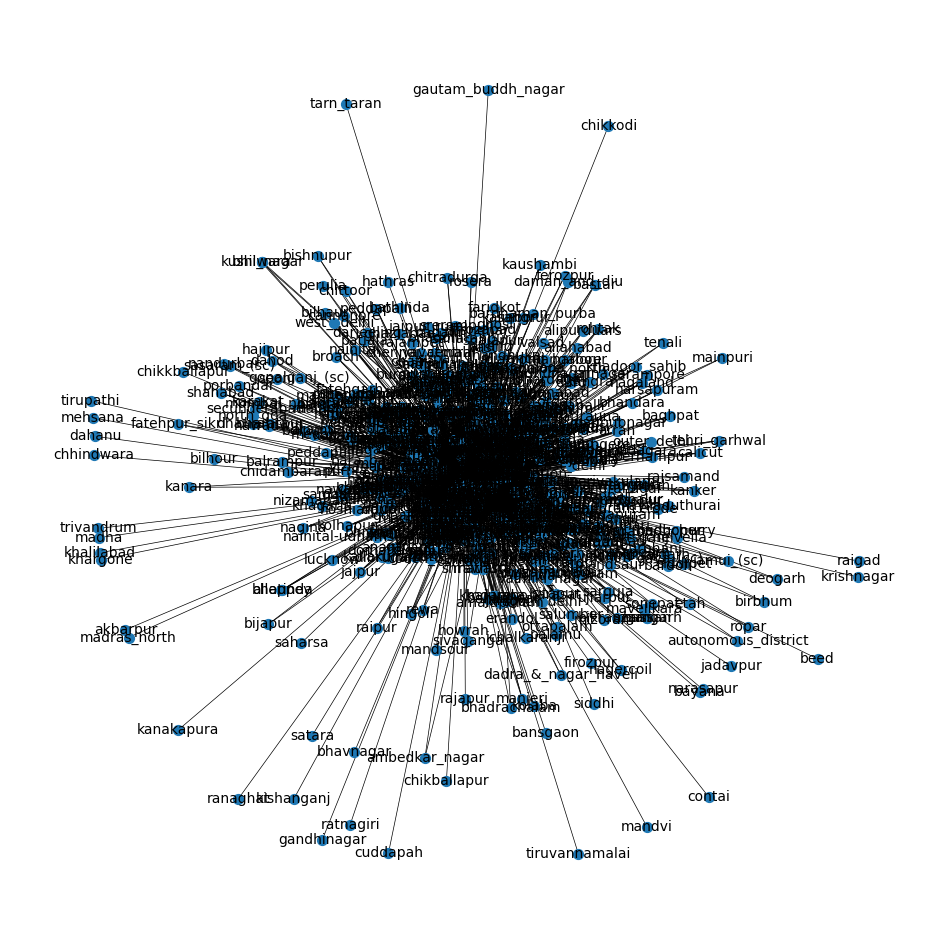

In [28]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a graph
G = nx.Graph()

# Add nodes
for constituency in network_edges['constituency'].unique():
    G.add_node(constituency, type='constituency')

for topic in network_edges['top_category'].unique():
    G.add_node(topic, type='topic')

# Add edges with weights
for _, row in network_edges.iterrows():
    G.add_edge(row['constituency'], row['top_category'], weight=row['weight'])

# Draw the network
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G)  # positions for all nodes
nx.draw_networkx_nodes(G, pos, node_size=50)
nx.draw_networkx_edges(G, pos, width=0.5)
nx.draw_networkx_labels(G, pos, font_size=10, font_family='sans-serif')

plt.axis('off')
plt.show()

In [20]:
df_long.to_csv('use_this.csv')

In [22]:
df_long.head()

,id,date,ls_number,ministry,question_type,question_text,answer_text,member,party,state,...,top_category,top_category_score,processed_results,development_score,corruption_score,programmatic representation_score,accountability and transparency_score,clientelistic representation_score,Year,gender_rep
0,17350913.0,1999-12-09,13.0,Rural Development,Unstarred,(a) whether any scheme is under consideation o...,MINISTER OF STATE FOR RURAL DEVELOPMENT (SHRI ...,ABDUL RASHID SHAHEEN,JKN,Jammu & Kashmir,...,programmatic representation,0.769578,{'programmatic representation': 0.769578337669...,0.193197,0.018498,0.769578,0.663415,0.239772,1962,1
1,17354313.0,1999-12-01,13.0,Prime Minister,Unstarred,(a) whether the Government propose to conduct ...,THE MINISTER OF STATE IN THE DEPARTMENT OF ATO...,T. GOVINDAN,CPM,Kerala,...,accountability and transparency,0.614412,{'accountability and transparency': 0.61441200...,0.259336,0.003222,0.410504,0.614412,0.292619,1962,1
2,17353813.0,1999-12-02,13.0,Rural Development,Unstarred,(a) The guidelines and directions issued by th...,Minister of State for RURAL DEVELOPMENT (SHRI ...,SAMAR CHOWDHURY,CPM,Tripura,...,programmatic representation,0.874857,{'programmatic representation': 0.874856531620...,0.505724,0.005591,0.874857,0.855427,0.305820,1962,1
3,10021313.0,2004-02-04,13.0,Shipping,Unstarred,(a) the time when the Sompen Hospital Ship arr...,MINISTER OF STATE IN THE MINISTRY OF SHIPPING ...,BISHNU PADA RAY,BJP,Andaman & Nicobar Islands,...,accountability and transparency,0.433297,{'accountability and transparency': 0.43329674...,0.021046,0.005672,0.187835,0.433297,0.340559,1962,1
4,16344514.0,2004-08-16,14.0,Tourism,Unstarred,(a) whether the Government has any proposal to...,MINISTER OF STATE FOR TOURISM (INDEPENDENT CHA...,MANORANJAN BHAKTA,INC,Andaman & Nicobar Islands,...,development,0.952534,"{'development': 0.9525343775749207, 'accountab...",0.952534,0.007300,0.682238,0.901977,0.583766,1962,1


### LDA

In [3]:
# loading in the textual data 
text_data = pd.read_csv("TCPD_QH.tsv", sep='\t', header=0, engine='python')

In [4]:
text_data.head()

,id,date,ls_number,ministry,question_type,question_text,answer_text,member,party,state,constituency,constituency_type,gender,subject,link
0,10173416,2017-08-02T00:00:00,16,Railways,Unstarred,(a) the number of cases which came to notice w...,MINISTER OF STATE IN THE MINISTRY OF RAILWAYS ...,RAJESH VERMA,BJP,Uttar Pradesh,Sitapur,GEN,Male,Cases of Fighting/Quarrels in Trains,https://loksabha.nic.in/Questions/QResult15.as...
1,10173216,2017-08-02T00:00:00,16,Information and Broadcasting,Unstarred,(a) the salient features of the Community Radi...,THE MINISTER OF STATE OF THE MINISTRY OF INFOR...,B. SREERAMULU,BJP,Karnataka,Bellary,ST,Male,Community Radio Station,https://loksabha.nic.in/Questions/QResult15.as...
2,10173116,2017-08-02T00:00:00,16,Skill Development and Entrepreneurship,Unstarred,(a) whether the India International Skill Cent...,(a) to (e) As on date 14 India International S...,"MEENAKASHI LEKHI, RAVINDRA KUMAR PANDEY","BJP, BJP","Delhi, Jharkhand","New delhi, Giridih","GEN, GEN","Female, Male",India International Skill Centre,https://loksabha.nic.in/Questions/QResult15.as...
3,10173016,2017-08-02T00:00:00,16,Housing and Urban Affairs,Unstarred,Will the Minister of HOUSING AND URBAN AFFAIRS...,THE MINISTER OF STATE IN THE MINISTRY OF HOUSI...,RAJENDRAN S,ADMK,Tamil Nadu,Viluppuram,SC,Male,MoU with Reckitt Benckiser,https://loksabha.nic.in/Questions/QResult15.as...
4,10172916,2017-08-02T00:00:00,16,Minority Affairs,Unstarred,(a) whether the Government proposes to carry o...,MINISTER OF STATE (INDEPENDENT CHARGE) FOR MIN...,DILIP PATEL,BJP,Gujarat,Anand,GEN,Male,Employment Surveys,https://loksabha.nic.in/Questions/QResult15.as...


In [4]:
df = text_data.copy()

In [11]:
# Download necessary NLTK datasets
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/bhavyapandey/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/bhavyapandey/nltk_data...


True

In [5]:
# cleaning data 
df = df.dropna()
df = df.astype(str)

In [17]:
# Define a function to process each row
def process_text(text):
    stop = set(stopwords.words('english'))
    stop.update(["mr", "mrs", "one", "two", "said", "minister", 'ministry', 'state', 'India', 'india'])  # add more stopwords as needed
    lemma = WordNetLemmatizer()
    normalized = " ".join(lemma.lemmatize(word) for word in text.lower().split() if word not in stop)
    return normalized

In [15]:
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/bhavyapandey/nltk_data...


True

In [20]:
# Sequential processing of text data
preprocessed_texts = [process_text(text) for text in df['question_text']]

In [21]:
# Tokenize words
texts = [[word for word in document.lower().split()] for document in preprocessed_texts]

# Create a dictionary representation of the documents
dictionary = corpora.Dictionary(texts)

# Filter out extremes to limit the number of features
dictionary.filter_extremes(no_below=5, no_above=0.5, keep_n=100000)

# Convert dictionary to a bag of words corpus
corpus = [dictionary.doc2bow(text) for text in texts]

# Apply LDA
lda_model = models.LdaModel(corpus, num_topics=20, id2word=dictionary, passes=5)

# View topics in LDA model
for idx, topic in lda_model.print_topics(-1):
    print(f"Topic: {idx} \nWords: {topic}")

Topic: 0 
Words: 0.060*"??" + 0.053*"employee" + 0.047*"worker" + 0.037*"organisation" + 0.035*"????" + 0.028*"working" + 0.027*"???" + 0.027*"?????" + 0.025*"social" + 0.023*"(a)whether"
Topic: 1 
Words: 0.038*"thereof;" + 0.027*"reaction" + 0.018*"thereof" + 0.018*"committee" + 0.018*"(e)" + 0.015*"thereto;" + 0.013*"report" + 0.013*"indian" + 0.012*"made" + 0.012*"recommendation"
Topic: 2 
Words: 0.041*"per" + 0.040*"coal" + 0.025*"rate" + 0.020*"tax" + 0.019*"cent" + 0.016*"growth" + 0.016*"year" + 0.016*"mine" + 0.014*"income" + 0.013*"amount"
Topic: 3 
Words: 0.036*"farmer" + 0.024*"loss" + 0.022*"due" + 0.021*"thereof;" + 0.020*"crore" + 0.018*"agricultural" + 0.016*"rs." + 0.015*"food" + 0.013*"thereof?" + 0.012*"price"
Topic: 4 
Words: 0.031*"thereof;" + 0.027*"education" + 0.021*"thereof?" + 0.019*"system" + 0.017*"proposes" + 0.017*"school" + 0.017*"quality" + 0.017*"training" + 0.014*"guideline" + 0.013*"telephone"
Topic: 5 
Words: 0.054*"pleased" + 0.042*"health" + 0.042*"

### Classifier Exploration - Manual Keywords Selection + Some Statistical Tests

In [6]:
stop = set(stopwords.words('english'))
lemma = WordNetLemmatizer()

def preprocess(text):
    return " ".join(lemma.lemmatize(word) for word in text.lower().split() if word not in stop)

df['processed_text'] = df['question_text'].apply(preprocess)

# Define your keywords for each category
keywords = {
    'corruption': ["bribery", "embezzlement", "kickbacks", "money laundering"],
    'development': ["infrastructure", "education", "healthcare", "economic growth"],
    'accountability': ["audit", "oversight", "disclosure", "transparency"],
    'programmatic': ["legislation", "policy reform", "national budget"],
    'clientelistic': ["local projects", "constituency services", "patronage"]
}

# Function to calculate score based on keyword presence
def calculate_score(text, keyword_list):
    return sum(1 for word in keyword_list if word in text)

# Calculate scores for each aspect
for aspect, keyword_list in keywords.items():
    df[f'{aspect}_score'] = df['processed_text'].apply(calculate_score, keyword_list=keyword_list)

# For programmatic vs. clientelistic representation, we assume a simple difference
df['representation_score'] = df['programmatic_score'] - df['clientelistic_score']


In [27]:
# Filter the DataFrame to include only rows where gender is either "Male" or "Female"
df = df[df['gender'].isin(['Male', 'Female'])]

In [28]:
# Calculate average scores by gender
average_scores_by_gender = df.groupby('gender').agg({
    'corruption_score': 'mean',
    'development_score': 'mean',
    'accountability_score': 'mean',
    'representation_score': 'mean',
}).reset_index()


In [29]:
print(average_scores_by_gender)

   gender  corruption_score  development_score  accountability_score  \
0  Female          0.000444           0.054556              0.007667   
1    Male          0.000817           0.047925              0.007403   

   representation_score  
0              0.004626  
1              0.003528  


In [32]:
print(df['gender'].value_counts())

gender
Male      193301
Female     15782
Name: count, dtype: int64


In [34]:
print(df['corruption_score'].isnull().sum())

0


In [35]:
from scipy.stats import ttest_ind

# for corruption score -- NOT STATISTICALLY SIGNIFICANT
male_scores = df[df['gender'] == 'Male']['corruption_score']
female_scores = df[df['gender'] == 'Female']['corruption_score']

t_stat, p_value = ttest_ind(male_scores, female_scores)
print(f"T-statistic: {t_stat}, P-value: {p_value}")

T-statistic: 1.598414892881993, P-value: 0.10995218343925084


In [36]:
# for development score -- STATISTICALLY SIGNIFICANT DIFFERENCE
# direction of this difference is such that female legislators might have a higher emphasis on development issues compared to male legislators
male_scores = df[df['gender'] == 'Male']['development_score']
female_scores = df[df['gender'] == 'Female']['development_score']

t_stat, p_value = ttest_ind(male_scores, female_scores)
print(f"T-statistic: {t_stat}, P-value: {p_value}")

T-statistic: -3.6300649166474006, P-value: 0.00028341750646661604


In [37]:
# for accountability score -- NOT STATISTICALLY SIGNIFICANT
male_scores = df[df['gender'] == 'Male']['accountability_score']
female_scores = df[df['gender'] == 'Female']['accountability_score']

t_stat, p_value = ttest_ind(male_scores, female_scores)
print(f"T-statistic: {t_stat}, P-value: {p_value}")

T-statistic: -0.3656252928382408, P-value: 0.7146450689430621


In [38]:
# for representation score -- STATISTICALLY SIGNIFICANT
# negative sign indicating that female legislators might have a higher emphasis on programmatic issues compared to male legislators
male_scores = df[df['gender'] == 'Male']['representation_score']
female_scores = df[df['gender'] == 'Female']['representation_score']

t_stat, p_value = ttest_ind(male_scores, female_scores)
print(f"T-statistic: {t_stat}, P-value: {p_value}")

T-statistic: -2.161512490004213, P-value: 0.030656904375772197


### Zero Shot Classification

In [7]:
df['processed_text'][0]

'(a) number case came notice regard fighting quarrel occurred train passenger year till date; (b) measure taken government prevent fight quarrel committed anti-social element train along detail thereof?'

In [8]:
from transformers import pipeline

# Initialize the zero-shot classification pipeline
classifier = pipeline("zero-shot-classification")

# Define your categories
categories = ['corruption', 'development', 'accountability and transparency', 'programmatic representation', 'clientelistic representation']

# Example text from your dataset
text = "The question addresses the need for improved infrastructure and healthcare facilities in rural areas to promote development."

# Perform classification
results = classifier(text, categories,  multi_class=True)

# Print categorized labels with their confidence scores
# for category, score in zip(results['labels'], results['scores']):
    # print(f"{category}: {score:.4f}")


No model was supplied, defaulted to facebook/bart-large-mnli and revision c626438 (https://huggingface.co/facebook/bart-large-mnli).
Using a pipeline without specifying a model name and revision in production is not recommended.


: 

In [1]:
import pandas as pd

In [2]:
dev = pd.read_stata("Results_dev.dta")

In [5]:
dev.head()

,point_estimate,se_point_estimate,lb_CI_95,up_CI_95,N,N_switchers,time_to_treat
0,-0.021389,0.103785,-0.224803,0.182025,80.0,27.0,-3.0
1,0.057929,0.115063,-0.167591,0.283449,82.0,27.0,-2.0
2,0.076842,0.068449,-0.057315,0.210999,319.0,238.0,-1.0
3,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
4,0.029581,0.034889,-0.038801,0.097963,955.0,602.0,1.0


In [3]:
dev.to_latex(index=False,
                  formatters={"name": str.upper},
                  float_format="{:.1f}".format,
)

'\\begin{tabular}{rrrrrrr}\n\\toprule\npoint_estimate & se_point_estimate & lb_CI_95 & up_CI_95 & N & N_switchers & time_to_treat \\\\\n\\midrule\n-0.0 & 0.1 & -0.2 & 0.2 & 80.0 & 27.0 & -3.0 \\\\\n0.1 & 0.1 & -0.2 & 0.3 & 82.0 & 27.0 & -2.0 \\\\\n0.1 & 0.1 & -0.1 & 0.2 & 319.0 & 238.0 & -1.0 \\\\\n0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 \\\\\n0.0 & 0.0 & -0.0 & 0.1 & 955.0 & 602.0 & 1.0 \\\\\n-0.0 & 0.0 & -0.1 & 0.1 & 507.0 & 391.0 & 2.0 \\\\\n0.0 & 0.1 & -0.1 & 0.1 & 120.0 & 31.0 & 3.0 \\\\\n0.0 & 0.0 & -0.0 & 0.1 & 109.0 & 30.0 & 4.0 \\\\\n-0.0 & 0.0 & -0.1 & 0.1 & 87.0 & 30.0 & 5.0 \\\\\n-0.0 & 0.0 & -0.1 & 0.1 & 85.0 & 30.0 & 6.0 \\\\\n0.0 & 0.0 & -0.0 & 0.1 & 82.0 & 30.0 & 7.0 \\\\\n0.1 & 0.0 & -0.0 & 0.1 & 81.0 & 30.0 & 8.0 \\\\\n\\bottomrule\n\\end{tabular}\n'

In [75]:
pip install --upgrade jinja2

Note: you may need to restart the kernel to use updated packages.
